## 🔍 What this script does

This notebook compares power measurements from two sources:

- 📟 **Raspberry Pi logger** (CSV: `energy_log_*.csv`)
- ⚡ **Siglent power meter** (CSV: `cpu1.csv`)

**Steps performed:**
1. Parses voltage and current readings from the Pi, and calculates power and cumulative energy (Wh)
2. Parses power measurements from the Siglent CSV
3. Resamples both datasets to 1-second intervals for direct comparison
4. Merges the two datasets by timestamp
5. Computes correlation and visualizes both datasets on a time plot

This helps validate whether the Pi-based measurement setup aligns closely with the calibrated Siglent readings.


In [1]:
# --- Imports ---
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime

# --- Helper Functions ---
def clean_columns(df):
    df.columns = [col.strip().lower().replace(" ", "_") for col in df.columns]
    return df

def find_col_like(df, keywords):
    for kw in keywords:
        for col in df.columns:
            if kw.lower() in col.lower():
                return col
    raise ValueError(f"No column matching any of {keywords}")

def coerce_units(series, name):
    name = name.lower()
    if "mv" in name:
        return series / 1000.0
    elif "ma" in name:
        return series / 1000.0
    elif "ua" in name or "µa" in name:
        return series / 1_000_000.0
    elif "kw" in name:
        return series * 1000.0
    return series


Siglent cols: ['index', 'time', 'minutes', 'datetime', 'spd33.ch1_voltage', 'spd33.ch1_current', 'spd33.ch1_power', 'unnamed:_7']
comp index type: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>
First 5 time values: DatetimeIndex([], dtype='datetime64[ns]', name='time', freq=None)
Power (W) samples:
 Empty DataFrame
Columns: [power_w, siglent_power_w]
Index: []
Pi total energy:      0.0000 Wh
Siglent total energy: 0.0000 Wh
Difference:           0.0000 Wh


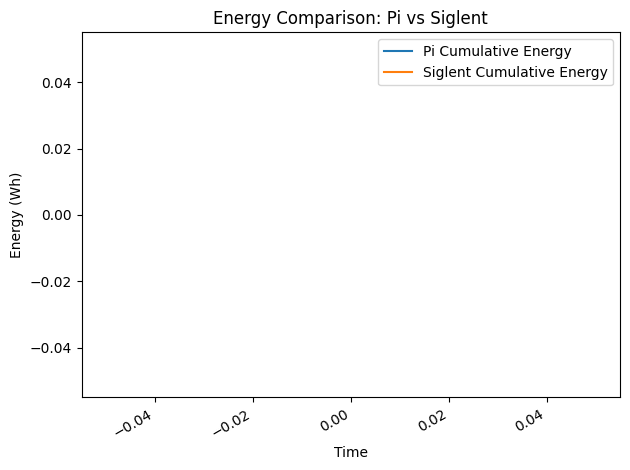

In [20]:
# --- Load and clean Siglent CSV ---
siglent_csv = "cpu1.csv"
s_raw = pd.read_csv(siglent_csv)
s = clean_columns(s_raw)
print("Siglent cols:", s.columns.tolist())

# Automatically detect time and power columns based on keywords
st = find_col_like(s, ["time", "timestamp", "date"])
sp = find_col_like(s, ["power", "w"])

# Create time-indexed dataframe from Siglent readings
sig = pd.DataFrame({
    "time": pd.to_datetime(s[st], errors='coerce'),  # Convert time column
    "siglent_power_w": pd.to_numeric(s[sp], errors="coerce")  # Ensure power is numeric
}).dropna().sort_values("time").set_index("time")  # Remove bad rows, sort and index by time
# --- Load and process Pi logger CSV ---
pi_csv = "energy_log_20250829_120521_521_cpu1.csv"
pi_raw = pd.read_csv(pi_csv)

# Convert ISO timestamps from Pi CSV to datetime index
pi = pd.DataFrame({
    "time": pd.to_datetime(pi_raw["Timestamp (ISO ms)"]),
    "voltage_v": pi_raw["Voltage (V)"],
    "current_a": pi_raw["Current (A)"],
    "power_w": pi_raw["Power (W)"]
}).dropna().sort_values("time").set_index("time")

# --- Resample to 1s resolution for fair comparison ---
pi1 = pi[["power_w"]].resample("1s").mean()
sg1 = sig.resample("1s").mean()
comp = pi1.join(sg1, how="inner").dropna()

# ✅ DEBUG: Check what's inside `comp` before integration
print("comp index type:", type(comp.index))
print("First 5 time values:", comp.index[:5])
print("Power (W) samples:\n", comp[['power_w', 'siglent_power_w']].head())

# ✅ Fix index if it's not datetime
if not isinstance(comp.index, pd.DatetimeIndex):
    comp.index = pd.to_datetime(comp.index)

# --- Compute cumulative energy ---
def integrate_energy_wh(index, power_series):
    dt = index.to_series().diff().dt.total_seconds().fillna(0)
    energy_joules = (power_series * dt).cumsum()
    energy_wh = energy_joules / 3600
    return energy_wh, energy_wh.iloc[-1] if not energy_wh.empty else 0

comp["pi_energy_Wh"], pi_total_Wh = integrate_energy_wh(comp.index, comp["power_w"])
comp["siglent_energy_Wh"], siglent_total_Wh = integrate_energy_wh(comp.index, comp["siglent_power_w"])

# --- Summary output ---
print(f"Pi total energy:      {pi_total_Wh:.4f} Wh")
print(f"Siglent total energy: {siglent_total_Wh:.4f} Wh")
print(f"Difference:           {pi_total_Wh - siglent_total_Wh:.4f} Wh")

# --- Plot energy curves ---
plt.figure()
comp["pi_energy_Wh"].plot(label="Pi Cumulative Energy")
comp["siglent_energy_Wh"].plot(label="Siglent Cumulative Energy")
plt.legend()
plt.title("Energy Comparison: Pi vs Siglent")
plt.ylabel("Energy (Wh)")
plt.xlabel("Time")
plt.tight_layout()
plt.show()


In [21]:
pi_csv = "energy_log_20250829_120521_521_cpu1.csv"  # adjust filename

df_raw = pd.read_csv(pi_csv)
df = clean_columns(df_raw)
print("Columns:", df.columns.tolist())

time_col = find_col_like(df, ["time","timestamp","date"])
volt_col = find_col_like(df, ["volt","v"])
curr_col = find_col_like(df, ["curr","amp","a","i"])
print("Detected:", time_col, volt_col, curr_col)

V = coerce_units(df[volt_col], volt_col)
I = coerce_units(df[curr_col], curr_col)
P = V * I

d = pd.DataFrame({
    "time": pd.to_datetime(df[time_col]),
    "voltage_v": V,
    "current_a": I,
    "power_w": P
}).dropna().sort_values("time").set_index("time")

cum_Wh, total_Wh = integrate_energy_wh(d.index, d["power_w"])
d["energy_Wh"] = cum_Wh
print("Total energy (Wh):", round(total_Wh, 6))

Columns: ['timestamp_(iso_ms)', 'voltage_(v)', 'current_(a)', 'power_(w)', 'dt_(s)', 'energy_so_far_(j)']
Detected: timestamp_(iso_ms) voltage_(v) current_(a)
Total energy (Wh): 0.104613


In [22]:
def clean_columns(df):
    df.columns = [col.strip().lower().replace(" ", "_") for col in df.columns]
    return df

def find_col_like(df, keywords):
    for kw in keywords:
        for col in df.columns:
            if kw.lower() in col.lower():
                return col
    raise ValueError(f"No column matching any of {keywords}")

In [23]:
print(d.head())                    # Check if any data exists
print(d[["power_w", "energy_Wh"]].describe())  # Look for NaNs or all-zeroes
print(d.index)                     # Ensure the index is datetime or meaningful

                         voltage_v  current_a   power_w  energy_Wh
time                                                              
2025-08-29 12:05:21.546   0.879731    0.86621  0.762032   0.000000
2025-08-29 12:05:21.644   0.879193    0.86621  0.761566   0.000021
2025-08-29 12:05:21.744   0.879193    0.86621  0.761566   0.000042
2025-08-29 12:05:21.844   0.878925    0.86621  0.761334   0.000063
2025-08-29 12:05:21.944   0.879193    0.85728  0.753715   0.000084
           power_w    energy_Wh
count  3600.000000  3600.000000
mean      1.046315     0.049025
std       0.574595     0.035209
min       0.407809     0.000000
25%       0.461292     0.015866
50%       0.816275     0.044458
75%       1.515280     0.082935
max       2.889239     0.104613
DatetimeIndex(['2025-08-29 12:05:21.546000', '2025-08-29 12:05:21.644000',
               '2025-08-29 12:05:21.744000', '2025-08-29 12:05:21.844000',
               '2025-08-29 12:05:21.944000', '2025-08-29 12:05:22.044000',
               '20

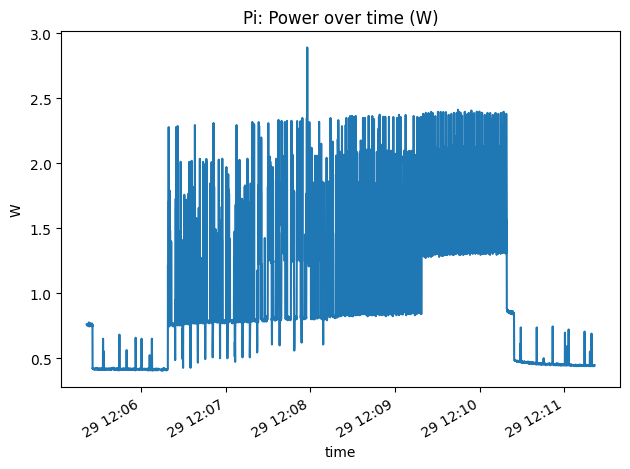

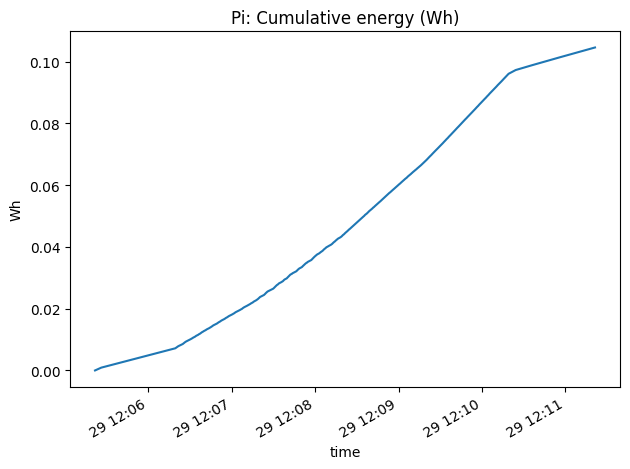

In [24]:

if d.empty or d[['power_w', 'energy_Wh']].isna().all().all():
    print("Warning: DataFrame 'd' is empty or columns contain only NaNs")
    print(d.describe())
else:
    plt.figure()
    d["power_w"].plot()
    plt.title("Pi: Power over time (W)")
    plt.ylabel("W")
    plt.xlabel("time")
    plt.tight_layout()
    plt.show()

    plt.figure()
    d["energy_Wh"].plot()
    plt.title("Pi: Cumulative energy (Wh)")
    plt.ylabel("Wh")
    plt.xlabel("time")
    plt.tight_layout()
    plt.show()


In [25]:

siglent_csv = "cpu1.csv"
s_raw = pd.read_csv(siglent_csv)  # ✅ Load the file first

# ✅ Now print info
print("Raw head:\n", s_raw.head())
print("\nColumn names:", s_raw.columns.tolist())
print("\nData summary:\n", s_raw.describe(include='all'))

# Continue with the rest of your cleaning and parsing
s = clean_columns(s_raw)
print("Siglent cols:", s.columns.tolist())

st = find_col_like(s, ["time","timestamp","date"])
sp = find_col_like(s, ["power","w"])

sig = pd.DataFrame({
    "time": pd.to_datetime(s[st], errors='coerce'),
    "siglent_power_w": pd.to_numeric(s[sp], errors="coerce")
}).dropna()

sig = sig.sort_values("time").set_index("time")

# Resample both to 1s using 's' (lowercase, per warning)
pi1 = d[["power_w"]].resample("1s").mean()
sg1 = sig.resample("1s").mean()

comp = pi1.join(sg1, how="inner").dropna()

if comp.empty:
    print("No overlapping data between Pi and Siglent after resampling.")
else:
    print(comp.head())
    print("Correlation:", comp["power_w"].corr(comp["siglent_power_w"]))

    plt.figure()
    comp["power_w"].plot(label="Pi")
    comp["siglent_power_w"].plot(label="Siglent")
    plt.legend()
    plt.title("Power comparison (Pi vs Siglent)")
    plt.ylabel("W")
    plt.tight_layout()
    plt.show()

print("Cleaned head:\n", sig.head())
print("Siglent index range:", sig.index.min(), "to", sig.index.max())
print("Pi index range:", d.index.min(), "to", d.index.max())


Raw head:
    index   time   minutes    dateTime  SPD33.CH1_Voltage  SPD33.CH1_Current  \
0      0  0.022  0.000367  1756803350                  5               0.45   
1      1  0.327  0.005450  1756803351                  5               0.46   
2      2  0.627  0.010450  1756803351                  5               0.46   
3      3  0.927  0.015450  1756803351                  5               0.46   
4      4  1.226  0.020433  1756803352                  5               0.46   

   SPD33.CH1_Power  Unnamed: 7  
0             2.25         NaN  
1             2.30         NaN  
2             2.30         NaN  
3             2.30         NaN  
4             2.30         NaN  

Column names: ['index', 'time', 'minutes', 'dateTime', 'SPD33.CH1_Voltage', 'SPD33.CH1_Current', 'SPD33.CH1_Power', 'Unnamed: 7']

Data summary:
              index         time      minutes      dateTime  SPD33.CH1_Voltage  \
count  1134.000000  1134.000000  1134.000000  1.134000e+03             1134.0   
mean   

Pi total energy:      0.0000 Wh
Siglent total energy: 0.0000 Wh
Difference:           0.0000 Wh


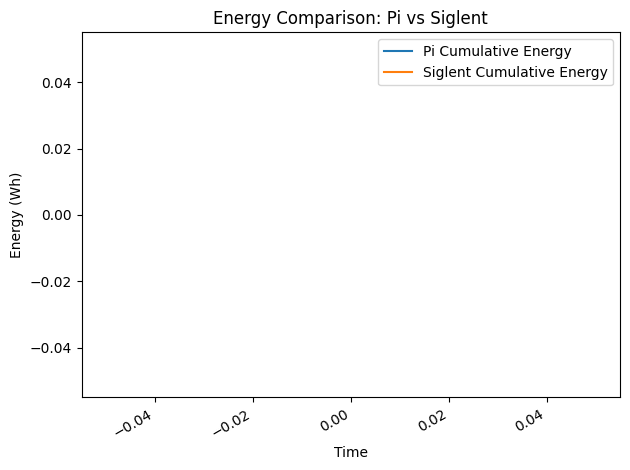

In [26]:
# --- Compute Siglent energy (Wh) using same integration method as Pi ---
def integrate_energy_wh(index, power_series):
    dt = index.to_series().diff().dt.total_seconds().fillna(0)
    energy_joules = (power_series * dt).cumsum()
    energy_wh = energy_joules / 3600
    return energy_wh, energy_wh.iloc[-1] if not energy_wh.empty else 0

# Integrate energy for both sources
comp["siglent_energy_Wh"], siglent_total_Wh = integrate_energy_wh(comp.index, comp["siglent_power_w"])
comp["pi_energy_Wh"], pi_total_Wh = integrate_energy_wh(comp.index, comp["power_w"])

# Print summary comparison
print(f"Pi total energy:      {pi_total_Wh:.4f} Wh")
print(f"Siglent total energy: {siglent_total_Wh:.4f} Wh")
print(f"Difference:           {pi_total_Wh - siglent_total_Wh:.4f} Wh")

# --- Plot energy curves ---
plt.figure()
comp["pi_energy_Wh"].plot(label="Pi Cumulative Energy")
comp["siglent_energy_Wh"].plot(label="Siglent Cumulative Energy")
plt.legend()
plt.title("Energy Comparison: Pi vs Siglent")
plt.ylabel("Energy (Wh)")
plt.xlabel("Time")
plt.tight_layout()
plt.show()
